In [1]:
import pandas as pd
import numpy as np
import alphalens
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
import empyrical

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('../')

In [4]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.导入数据

In [5]:
# alpha = pd.read_csv('./Output/alpha_daily_return(5%Significance).csv',index_col = 0)
# alpha = pd.read_csv('./Output/alpha_daily_return(noSignificance).csv',index_col = 0)
alpha = pd.read_csv('./Output/alpha_daily_return(all).csv',index_col = 0)
alpha.index = pd.to_datetime(alpha.index)

In [6]:
# 导入净值数据
# 基金数据，并分类到股票型基金
nv_2010to2014 = pd.read_csv("./Data/AdjustedNav(2010to2014).csv",index_col = 0)
nv_2015to2018 = pd.read_csv("./Data/AdjustedNav(2015to2018).csv",index_col = 0)
nv_2019to2022 = pd.read_csv("./Data/AdjustedNav(2019to2022).csv",index_col = 0)

In [7]:
nv = pd.concat([nv_2010to2014,nv_2015to2018,nv_2019to2022])

In [8]:
nv.index = pd.to_datetime(nv.index)

In [9]:
filled_nv = nv.asfreq("D").ffill()

In [10]:
# 导入基金经理离任数据
manager_info = pd.read_csv("./Data/ChinaMutualFundManager.csv",encoding = "gbk")

In [11]:
# 导入货币市场基金，不买货币市场基金
# 导入股票型、偏股型和灵活配置型基金
currency_fund = pd.read_excel("./Data/CurrencyFund.xlsx",index_col = 0)
stk_mutual_fund = pd.read_excel("./Data/StkMutualFundInfo.xlsx",index_col = 0)

In [12]:
stk_mutual_fund.query("FUND_TYPE == '普通股票型基金' or FUND_TYPE == '偏股混合型基金'",inplace = True)

#### 2.回测

In [13]:
@dataclass
class FundClass:
    vt_symbol:str = " "
    buy_price:float = 0.0
    volume:int = 0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.buy_price
        self.pnl = (self.price - self.buy_price)*self.volume
        self.daily_pnl = (self.price - self.last_price)*self.volume
        self.status = "HOLDING"

In [14]:
"""variables"""

"""paramaters"""
start_date = pd.to_datetime("2013-12-31")
end_date = pd.to_datetime("2022-03-31")
buy_cost:float = 0.005
sell_cost:float = 0.005
"""account infomation"""
in_position_fund:dict = {} 
balance:float = 300000.0
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_NAV"])

In [15]:
for date in pd.date_range(start_date,end_date): # 每天都进行循环更新
    
    if date in alpha.index and date.month % 3 == 0:
        # seasonal adjustment
#         to_buy_position = alpha.loc[date].dropna() # alpha > 0
        to_buy_position = alpha.loc[date].dropna().sort_values(ascending = False).iloc[:int(len(alpha.loc[date].dropna())*0.1)] # all alpha version
        # clear
        for to_sell_fund in in_position_fund.keys():
            # update when at the end of the month
            in_position_fund[to_sell_fund].last_price = in_position_fund[to_sell_fund].price
            in_position_fund[to_sell_fund].price = filled_nv.at[date,to_sell_fund]
            in_position_fund[to_sell_fund].pnl = (in_position_fund[to_sell_fund].price - \
                                                  in_position_fund[to_sell_fund].buy_price)*in_position_fund[to_sell_fund].volume
            in_position_fund[to_sell_fund].daily_pnl = (in_position_fund[to_sell_fund].price - \
                                                        in_position_fund[to_sell_fund].last_price)*in_position_fund[to_sell_fund].volume
            # sell
            if to_sell_fund not in to_buy_position:
                sell_price = filled_nv.at[date,to_sell_fund]
                print(f"sell {to_sell_fund} at {sell_price}")
                in_position_fund[to_sell_fund].status = "SOLD"
        
        # adjust
        for to_adjust_fund in in_position_fund.keys():
            if in_position_fund[to_adjust_fund].status == "HOLDING":
                price = filled_nv.at[date,to_adjust_fund]
                target_volume = balance/len(to_buy_position)/(price*(1+sell_cost))
                present_volume = in_position_fund[to_adjust_fund].volume
                if target_volume > present_volume:
                    pass
                else:
                    balance += (present_volume - target_volume)*(price - in_position_fund[to_adjust_fund].last_price)
                    balance -= (present_volume - target_volume)*price*sell_cost # sell cost
                    in_position_fund[to_adjust_fund].volume = target_volume
                    in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                            in_position_fund[to_adjust_fund].buy_price) * in_position_fund[to_adjust_fund].volume
                    in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                                  in_position_fund[to_adjust_fund].last_price) * in_position_fund[to_adjust_fund].volume
                    print(f"adjust {to_adjust_fund} from {present_volume} to {target_volume}")

        # buy
        for to_buy_fund in to_buy_position.index:
            if to_buy_fund not in in_position_fund.keys() and to_buy_fund not in currency_fund.index:
                buy_price = filled_nv.at[date,to_buy_fund]
                in_position_fund[to_buy_fund] = FundClass(
                    vt_symbol = to_buy_fund,
                    buy_price = buy_price,
                    volume = balance/len(to_buy_position)/(buy_price*(1+buy_cost)),
                )
                balance -= buy_price*(balance/len(to_buy_position)/buy_price)*buy_cost # buy cost
                print(f"buy {to_buy_fund} at {buy_price}")
                
    else:
        # 平日更新
        for to_adjust_fund in in_position_fund.keys():
            price = filled_nv.at[date,to_adjust_fund]
            in_position_fund[to_adjust_fund].last_price = in_position_fund[to_adjust_fund].price
            in_position_fund[to_adjust_fund].price = price
            in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                    in_position_fund[to_adjust_fund].buy_price)*in_position_fund[to_adjust_fund].volume
            in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                          in_position_fund[to_adjust_fund].last_price)*in_position_fund[to_adjust_fund].volume
            
    for to_compute_pnl_fund in list(in_position_fund.keys()):
        balance += in_position_fund[to_compute_pnl_fund].daily_pnl
        if in_position_fund[to_compute_pnl_fund].status == "SOLD":
            balance -= in_position_fund[to_compute_pnl_fund].price*in_position_fund[to_compute_pnl_fund].volume*sell_cost # sell cost
            del in_position_fund[to_compute_pnl_fund]
    backtest_result.loc[date,"ACCOUNT_NAV"] = balance

buy 160505.OF at 5.26346793
buy 519093.OF at 1.094
buy 000251.OF at 1.086
buy 070027.OF at 1.2406
buy 519087.OF at 3.77757824
buy 160512.OF at 1.2153
buy 202007.OF at 1.99879408
buy 160607.OF at 2.59136075
buy 920011.OF at 1.1069287
buy 860006.OF at 1.28500727
buy 590005.OF at 1.0888
buy 320011.OF at 1.1416
buy 180031.OF at 1.3549
buy 040011.OF at 1.4167
buy 460002.OF at 0.94580072
buy 270007.OF at 0.6969
buy 420005.OF at 1.1328
buy 952004.OF at 0.9912
buy 770001.OF at 1.1909
buy 163110.OF at 1.058
buy 080012.OF at 1.6345
buy 020009.OF at 2.08143998
buy 200008.OF at 0.7241
buy 160215.OF at 0.855
buy 163415.OF at 1.043
buy 952009.OF at 1.126
buy 460009.OF at 0.9532
buy 050001.OF at 3.64057516
buy 233009.OF at 1.101
buy 360007.OF at 0.7573
buy 202005.OF at 2.73720042
buy 090001.OF at 3.994369
buy 080008.OF at 1.0657
buy 213002.OF at 1.80291374
buy 860018.OF at 1.0429
buy 050201.OF at 1.73674885
buy 571002.OF at 1.2043
buy 360011.OF at 1.2782
buy 162202.OF at 5.01404917
buy 470098.OF at 1

sell 160505.OF at 8.49306497
sell 952035.OF at 1.1735
sell 000126.OF at 1.144
sell 000270.OF at 1.206
sell 400020.OF at 1.1962
sell 000550.OF at 1.69
sell 000219.OF at 1.246
sell 970020.OF at 0.95
sell 233009.OF at 1.5049
sell 000017.OF at 1.8696
sell 217012.OF at 1.274
sell 460009.OF at 1.0144
sell 860016.OF at 1.067
sell 481008.OF at 1.5708
sell 519983.OF at 1.34
sell 320005.OF at 2.03380985
sell 580005.OF at 1.28310437
sell 630015.OF at 1.8482
sell 420003.OF at 1.5875
sell 206012.OF at 0.997
sell 590005.OF at 1.7441
sell 420005.OF at 1.4155
sell 213003.OF at 1.74058944
sell 398041.OF at 1.0538
sell 000573.OF at 1.0701
sell 240022.OF at 1.008
sell 519678.OF at 1.421
sell 750001.OF at 1.5986
sell 217020.OF at 1.4277
sell 700004.OF at 1.188
sell 253010.OF at 1.93206805
sell 166020.OF at 1.1533
sell 050014.OF at 1.2417
sell 000065.OF at 1.3188
sell 160220.OF at 1.112
sell 519158.OF at 1.324
sell 400023.OF at 1.0975
sell 360005.OF at 4.0155554
sell 110025.OF at 0.838
sell 050010.OF at 1.

sell 000574.OF at 1.7359
sell 860016.OF at 1.388
sell 000925.OF at 1.039
sell 000584.OF at 1.545
sell 000739.OF at 1.406
sell 000410.OF at 2.189
sell 000404.OF at 2.129
sell 000663.OF at 1.9861
sell 519156.OF at 2.183
sell 100056.OF at 2.55
sell 519120.OF at 1.983
sell 000124.OF at 1.8766
sell 970016.OF at 1.71004959
sell 673010.OF at 1.744
sell 000522.OF at 1.562
sell 880007.OF at 2.21245774
sell 000619.OF at 1.812
sell 110029.OF at 3.91663349
sell 110013.OF at 3.6763
sell 519068.OF at 2.35483023
sell 000220.OF at 1.814
sell 470009.OF at 3.0913
sell 900011.OF at 1.71554632
sell 000870.OF at 1.425
sell 762001.OF at 2.63093019
sell 519969.OF at 1.264
sell 000646.OF at 1.16
sell 110015.OF at 1.9301
sell 000480.OF at 1.7775
sell 000587.OF at 1.699
sell 070022.OF at 1.923
sell 000697.OF at 1.426
sell 519095.OF at 2.4581
sell 519026.OF at 0.991
sell 070002.OF at 11.49119892
sell 630002.OF at 4.4298
sell 870005.OF at 0.9683
sell 630010.OF at 2.5117
sell 000729.OF at 1.339
sell 270025.OF at 1

sell 169101.OF at 1.6774
sell 910024.OF at 1.76885064
sell 000279.OF at 2.058
sell 169102.OF at 1.3243
sell 001457.OF at 1.2019
sell 001154.OF at 0.994
sell 161224.OF at 1.1358
sell 260112.OF at 1.8295
sell 000845.OF at 1.552
sell 200010.OF at 2.1912
sell 000963.OF at 1.169
sell 210004.OF at 1.941
sell 519704.OF at 2.235
sell 519918.OF at 1.4305
sell 610002.OF at 2.06603014
sell 202005.OF at 4.88744193
sell 000970.OF at 1.32
sell 920011.OF at 1.95384284
sell 610005.OF at 1.1011
sell 000251.OF at 2.315
sell 001181.OF at 0.897
sell 000172.OF at 1.9332
sell 000877.OF at 1.1916
sell 233011.OF at 1.9981
sell 001068.OF at 0.883
sell 001339.OF at 0.9697
sell 001074.OF at 0.8024
sell 001564.OF at 1.01
sell 161225.OF at 0.903
sell 233007.OF at 2.31
sell 000904.OF at 1.1329
sell 750001.OF at 1.7117
sell 001117.OF at 0.793
sell 501001.OF at 1.019
sell 090011.OF at 1.421
sell 040011.OF at 2.3072
sell 000458.OF at 1.1839
sell 952004.OF at 1.79948802
sell 233015.OF at 1.897
sell 001273.OF at 1.007
s

sell 519983.OF at 2.6353
sell 166005.OF at 2.177
sell 001449.OF at 1.213
sell 519975.OF at 1.4816
sell 180012.OF at 3.68383902
sell 110025.OF at 0.92
sell 240022.OF at 1.203
sell 001054.OF at 0.969
sell 001938.OF at 1.2678
sell 001302.OF at 1.194
sell 001951.OF at 1.076
sell 001705.OF at 1.133
sell 001558.OF at 0.7365
sell 270041.OF at 2.049
sell 160212.OF at 2.349
sell 160211.OF at 3.4299
sell 360010.OF at 1.7306
sell 001140.OF at 0.969
sell 000654.OF at 1.4252
sell 000763.OF at 1.505
sell 210002.OF at 2.9097
sell 481008.OF at 1.5522
sell 210007.OF at 1.168
sell 001500.OF at 1.194
sell 168101.OF at 1.337
sell 001528.OF at 1.073
sell 519710.OF at 1.173
sell 519965.OF at 1.249
sell 100022.OF at 7.495154
sell 398061.OF at 2.5522
sell 001017.OF at 1.406
sell 630006.OF at 1.3931
sell 000423.OF at 1.098
sell 000628.OF at 1.208
sell 610005.OF at 1.2882
sell 001959.OF at 0.922
sell 519704.OF at 2.602
sell 001298.OF at 1.003
sell 000991.OF at 0.957
sell 210009.OF at 1.5856
sell 000747.OF at 1.

sell 000849.OF at 1.8426
sell 540006.OF at 2.9046
sell 001810.OF at 1.269
sell 920011.OF at 2.26038738
sell 001471.OF at 1.124
sell 952004.OF at 2.12586689
sell 519702.OF at 1.7314
sell 410009.OF at 1.0863
sell 001421.OF at 1.284
sell 519688.OF at 5.54353682
sell 519191.OF at 1.183
sell 000523.OF at 1.7234
sell 000362.OF at 2.1882
sell 519712.OF at 2.2944
sell 001942.OF at 1.146
sell 040011.OF at 2.765
sell 260112.OF at 2.1641
sell 519697.OF at 3.186
sell 001577.OF at 1.053
sell 002334.OF at 1.2014
sell 000877.OF at 1.4865
sell 001564.OF at 1.246
sell 001635.OF at 1.13
sell 002307.OF at 1.086
sell 001694.OF at 1.304
sell 000172.OF at 2.3083
sell 519993.OF at 3.42106515
sell 001074.OF at 0.9642
sell 001173.OF at 1.129
sell 210004.OF at 2.5367
sell 000904.OF at 1.1958
sell 000458.OF at 1.3695
sell 002564.OF at 1.06350841
sell 001449.OF at 1.279
sell 001528.OF at 1.192
sell 000410.OF at 2.636
sell 160512.OF at 2.6362
sell 580007.OF at 1.4942
sell 001974.OF at 1.175
sell 161225.OF at 1.115

sell 910024.OF at 3.00384395
sell 000457.OF at 2.4361
sell 519156.OF at 3.036
sell 002121.OF at 1.313
sell 376510.OF at 1.718
sell 001583.OF at 1.243
sell 370027.OF at 2.055
sell 377010.OF at 6.56862732
sell 000020.OF at 2.172
sell 001733.OF at 1.128
sell 001222.OF at 0.946
sell 001018.OF at 1.569
sell 090009.OF at 1.581
sell 000328.OF at 1.828
sell 610005.OF at 1.2727
sell 001323.OF at 1.122
sell 519694.OF at 1.22260075
sell 260103.OF at 4.99625516
sell 375010.OF at 6.51535455
sell 001938.OF at 1.716
sell 001060.OF at 1.185
sell 160212.OF at 2.882
sell 519991.OF at 2.48452305
sell 001753.OF at 0.956
sell 550002.OF at 4.02049326
sell 090013.OF at 2.472
sell 000628.OF at 1.489
sell 290004.OF at 1.55397423
sell 519672.OF at 2.317
sell 519674.OF at 2.7357
sell 160910.OF at 2.47477496
sell 090007.OF at 4.3977
sell 001120.OF at 0.7187
sell 519019.OF at 5.1462232
sell 519959.OF at 1.076
sell 003446.OF at 1.2034
sell 040008.OF at 3.76874018
sell 290011.OF at 2.0456
sell 003145.OF at 1.0344
se

sell 001410.OF at 1.486
sell 003940.OF at 1.4732
sell 001542.OF at 2.039
sell 001048.OF at 1.414
sell 519606.OF at 2.1669
sell 100056.OF at 2.909
sell 377240.OF at 2.948
sell 020026.OF at 3.8505
sell 000755.OF at 1.2625
sell 020001.OF at 13.14838018
sell 169103.OF at 1.6994
sell 160215.OF at 2.2405
sell 000742.OF at 2.9211
sell 002692.OF at 1.044
sell 162607.OF at 5.09410897
sell 260101.OF at 10.14295214
sell 100060.OF at 2.4019
sell 519196.OF at 1.469
sell 519195.OF at 1.5762
sell 519005.OF at 3.03914059
sell 001897.OF at 1.1861
sell 002168.OF at 1.49
sell 000219.OF at 1.4856
sell 001740.OF at 1.465
sell 000772.OF at 1.357
sell 000925.OF at 1.217
sell 370024.OF at 2.996
sell 580005.OF at 1.59673051
sell 001694.OF at 1.503
sell 121003.OF at 2.20009241
sell 519193.OF at 1.1784
sell 001829.OF at 1.002
sell 001158.OF at 0.738
sell 001967.OF at 1.126
sell 379010.OF at 2.1385
sell 001125.OF at 0.796
sell 000612.OF at 2.1866
sell 000433.OF at 1.264
sell 161219.OF at 2.959
sell 001809.OF at 1

sell 000970.OF at 2.302
sell 002803.OF at 1.722
sell 169105.OF at 1.69
sell 001975.OF at 1.667
sell 003624.OF at 1.1164
sell 001728.OF at 1.157
sell 519778.OF at 1.1748
sell 519704.OF at 3.1035
sell 002482.OF at 1.229
sell 002214.OF at 1.5393
sell 398061.OF at 3.0622
sell 001186.OF at 1.068
sell 004091.OF at 1.1966
sell 519736.OF at 2.5329
sell 100020.OF at 11.058774
sell 000936.OF at 1.6025
sell 398021.OF at 1.15177823
sell 001679.OF at 0.845
sell 163411.OF at 1.90565466
sell 630011.OF at 1.9995
sell 000690.OF at 0.929
sell 004263.OF at 1.275
sell 001605.OF at 1.186
sell 001215.OF at 0.921
sell 630005.OF at 1.788
sell 002624.OF at 1.345
sell 003119.OF at 1.243
sell 003279.OF at 1.0164
sell 003886.OF at 1.2431
sell 001837.OF at 1.421
sell 002443.OF at 1.3405
sell 004477.OF at 1.2255
sell 002121.OF at 1.417
sell 519019.OF at 5.58312761
sell 004292.OF at 1.2067
sell 001120.OF at 0.6629
sell 001915.OF at 1.017
sell 090013.OF at 2.674
sell 210001.OF at 3.9266937
sell 000979.OF at 1.067
sel

sell 519091.OF at 2.623
sell 110025.OF at 0.985
sell 160627.OF at 1.2756
sell 240022.OF at 1.3822
sell 001985.OF at 1.262
sell 040020.OF at 1.6192
sell 000584.OF at 1.957
sell 169104.OF at 1.6159
sell 004505.OF at 1.074
sell 000531.OF at 1.317
sell 519700.OF at 2.1707
sell 000991.OF at 1.13
sell 001951.OF at 0.981
sell 001266.OF at 0.9203
sell 410009.OF at 0.9632
sell 003955.OF at 1.3186
sell 290012.OF at 1.3646
sell 001583.OF at 1.247
sell 519212.OF at 1.0118
sell 210007.OF at 0.829
sell 000523.OF at 1.8294
sell 519185.OF at 2.269
sell 001518.OF at 1.9684
sell 410007.OF at 1.9501
sell 002244.OF at 1.0464
sell 001223.OF at 1.061
sell 003175.OF at 1.1085
sell 080015.OF at 0.719
sell 001581.OF at 1.3761
sell 050008.OF at 3.03326595
sell 161225.OF at 1.1345
sell 410003.OF at 1.20753871
sell 001256.OF at 1.177
sell 000688.OF at 1.4415
sell 519191.OF at 1.1271
sell 003751.OF at 0.9866
sell 001227.OF at 0.569
sell 590008.OF at 3.24
sell 519773.OF at 0.782
sell 004075.OF at 1.2881
sell 000697

sell 040015.OF at 2.19584674
sell 000279.OF at 2.18441105
sell 519772.OF at 1.399
sell 002910.OF at 0.9325
sell 210008.OF at 1.45499866
sell 519196.OF at 1.39669976
sell 000219.OF at 1.37260661
sell 001268.OF at 0.548
sell 001717.OF at 1.335
sell 000831.OF at 1.397
sell 000432.OF at 1.451
sell 050026.OF at 1.60320053
sell 519020.OF at 1.00314279
sell 003598.OF at 1.035
sell 005265.OF at 0.8758
sell 160215.OF at 1.99884788
sell 020001.OF at 11.66794815
sell 005094.OF at 0.9148
sell 001576.OF at 0.983
sell 004986.OF at 1.0771441
sell 690007.OF at 2.222
sell 000884.OF at 1.279
sell 690004.OF at 1.579
sell 163415.OF at 2.44834834
sell 003834.OF at 0.852
sell 002259.OF at 1.101
sell 005235.OF at 0.9755
sell 161722.OF at 1.065
sell 000867.OF at 0.97590917
sell 160603.OF at 6.43936518
sell 002482.OF at 1.058
sell 570007.OF at 1.438
sell 005268.OF at 0.8368
sell 952009.OF at 2.70837889
sell 260104.OF at 8.92953502
sell 166019.OF at 1.91893541
sell 166301.OF at 2.363
sell 001195.OF at 0.583
sel

sell 519712.OF at 2.61090502
sell 000924.OF at 0.98007825
sell 000220.OF at 1.705
sell 519697.OF at 3.53582598
sell 399011.OF at 2.0195021
sell 000878.OF at 1.306
sell 519698.OF at 1.36707582
sell 519767.OF at 0.892558
sell 001508.OF at 1.304
sell 005176.OF at 1.0503
sell 001417.OF at 0.851
sell 001766.OF at 0.838
sell 161606.OF at 3.21937328
sell 001558.OF at 0.6699
sell 000727.OF at 0.869
sell 004905.OF at 0.9183
sell 213001.OF at 4.05830155
sell 163001.OF at 1.14599043
sell 002264.OF at 0.876
sell 002137.OF at 1.0195
sell 470006.OF at 1.31731531
sell 002229.OF at 1.15578982
sell 110023.OF at 1.391
sell 519961.OF at 0.8935
sell 000711.OF at 1.196
sell 000945.OF at 1.153
sell 000960.OF at 0.951
sell 003095.OF at 1.04142096
sell 004851.OF at 0.932
sell 000913.OF at 0.8741
sell 161616.OF at 1.22191961
sell 001815.OF at 1.09090034
sell 519171.OF at 0.643
sell 398041.OF at 0.98727521
sell 240020.OF at 1.77222174
sell 002863.OF at 0.979
sell 001167.OF at 0.492
sell 005001.OF at 0.9651
sell

sell 002620.OF at 1.389
sell 001410.OF at 1.70860597
sell 001357.OF at 1.31420395
sell 002708.OF at 1.34
sell 001500.OF at 1.50175392
sell 002862.OF at 0.848
sell 880007.OF at 2.23035426
sell 002563.OF at 1.191
sell 610004.OF at 1.429
sell 002980.OF at 1.092
sell 004616.OF at 1.32
sell 398011.OF at 2.87183891
sell 001574.OF at 1.039
sell 000794.OF at 1.303
sell 217021.OF at 2.166
sell 000746.OF at 1.729
sell 161706.OF at 5.80676574
sell 000117.OF at 1.653
sell 610002.OF at 3.1777527
sell 001701.OF at 1.101
sell 002692.OF at 1.171
sell 001938.OF at 2.04426392
sell 001811.OF at 1.46210021
sell 005505.OF at 1.3639
sell 501046.OF at 1.1554
sell 720001.OF at 2.51184908
sell 320016.OF at 1.645
sell 000601.OF at 1.2452375
sell 003853.OF at 1.47453389
sell 003304.OF at 1.214
sell 002558.OF at 1.372
sell 004314.OF at 1.1372
sell 003984.OF at 1.0879
sell 001480.OF at 0.97
sell 001616.OF at 1.339
sell 002168.OF at 1.466
sell 004640.OF at 0.7991
sell 005037.OF at 0.8146
sell 000031.OF at 1.614
sel

sell 001071.OF at 1.26
sell 519778.OF at 1.3669
sell 070021.OF at 1.71
sell 519727.OF at 1.62495817
sell 162201.OF at 8.65279716
sell 001955.OF at 1.358
sell 005711.OF at 1.3734
sell 002407.OF at 1.47496832
sell 001518.OF at 2.29473666
sell 006216.OF at 1.4651
sell 001103.OF at 1.64961984
sell 519191.OF at 1.27757412
sell 519212.OF at 1.1701
sell 001278.OF at 1.60943822
sell 001141.OF at 1.442
sell 519193.OF at 1.4417
sell 000308.OF at 2.75
sell 519185.OF at 2.53968854
sell 161910.OF at 1.2564
sell 005794.OF at 1.3471
sell 002281.OF at 1.0615
sell 001178.OF at 1.61255708
sell 004505.OF at 1.414
sell 001040.OF at 1.127
sell 501051.OF at 1.0594
sell 001782.OF at 1.39598248
sell 519087.OF at 6.16112447
sell 519002.OF at 2.00061211
sell 004868.OF at 1.2299
sell 460007.OF at 1.703
sell 860007.OF at 1.75864769
sell 006430.OF at 1.2023
sell 003980.OF at 1.0992
sell 001728.OF at 1.251
sell 000970.OF at 2.354
sell 860018.OF at 1.5055
sell 003516.OF at 1.2515
sell 001874.OF at 1.50209916
sell 51

sell 164205.OF at 1.4873
sell 161818.OF at 1.4286407
sell 000574.OF at 2.20215319
sell 001445.OF at 1.658
sell 001487.OF at 1.45943936
sell 040005.OF at 6.28551522
sell 260104.OF at 12.90879476
sell 260108.OF at 4.50316191
sell 001543.OF at 1.669
sell 162605.OF at 12.23249693
sell 260109.OF at 6.08500426
sell 001382.OF at 1.34
sell 005106.OF at 1.2753
sell 001117.OF at 1.11
sell 952004.OF at 3.16448256
sell 005848.OF at 1.4617
sell 050022.OF at 2.42885436
sell 000083.OF at 4.426
sell 001832.OF at 1.253
sell 270022.OF at 1.0149803
sell 003889.OF at 2.2816
sell 000971.OF at 0.91
sell 110022.OF at 2.886
sell 005585.OF at 1.3574
sell 210005.OF at 1.417
sell 001857.OF at 1.21
sell 000294.OF at 2.74082105
sell 003940.OF at 1.66048789
sell 005379.OF at 1.2776
sell 200008.OF at 1.57315183
sell 005620.OF at 1.243
sell 501065.OF at 1.34059178
sell 002621.OF at 1.579
sell 001679.OF at 1.325
sell 180012.OF at 7.03088395
sell 005264.OF at 1.3103
sell 160421.OF at 1.1945
sell 519644.OF at 1.213
sell

sell 673060.OF at 1.3555335
sell 004496.OF at 1.4358
sell 161903.OF at 5.56607815
sell 003955.OF at 1.7931
sell 006154.OF at 1.7433
sell 161810.OF at 2.087847
sell 050010.OF at 2.91183321
sell 001162.OF at 1.301
sell 001302.OF at 1.066
sell 003304.OF at 1.32038503
sell 005541.OF at 1.54970046
sell 005505.OF at 1.4604
sell 050026.OF at 2.55013975
sell 001508.OF at 2.234
sell 004209.OF at 1.259
sell 398041.OF at 1.66649652
sell 000727.OF at 1.624
sell 004851.OF at 1.7051
sell 501070.OF at 1.32197092
sell 519674.OF at 4.0288
sell 001210.OF at 0.8439
sell 002666.OF at 1.49186333
sell 006113.OF at 1.5971
sell 003745.OF at 1.5628
sell 001864.OF at 1.447
sell 257070.OF at 2.40785247
sell 005179.OF at 1.2942
sell 002692.OF at 1.544
sell 398001.OF at 6.45943321
sell 610005.OF at 1.24878754
sell 005453.OF at 1.2992
sell 001574.OF at 1.314
sell 006879.OF at 1.6206
sell 001071.OF at 2.017
sell 006642.OF at 1.59859165
sell 040015.OF at 3.07542427
sell 001645.OF at 2.152
sell 001410.OF at 2.42078734

sell 003304.OF at 1.56885562
sell 398041.OF at 2.07222606
sell 003634.OF at 1.7713
sell 003751.OF at 1.4094
sell 001880.OF at 1.6896
sell 164403.OF at 1.491
sell 005106.OF at 1.9173
sell 007835.OF at 1.5716
sell 006002.OF at 2.7844
sell 001717.OF at 3.371
sell 001579.OF at 2.13
sell 001171.OF at 1.673
sell 920003.OF at 3.53412191
sell 001940.OF at 1.6953
sell 004496.OF at 1.596
sell 001915.OF at 2.045
sell 001543.OF at 2.269
sell 501001.OF at 1.611
sell 410003.OF at 2.25642882
sell 004634.OF at 1.657
sell 005620.OF at 2.1937
sell 002621.OF at 2.82
sell 006675.OF at 1.389
sell 000423.OF at 1.904
sell 005303.OF at 2.0225
sell 004895.OF at 1.55558652
sell 004942.OF at 1.2179
sell 006218.OF at 1.9431
sell 001069.OF at 2.177
sell 002708.OF at 2.5
sell 161616.OF at 3.36580797
sell 002408.OF at 2.2087
sell 005176.OF at 2.9071
sell 003230.OF at 2.61528891
sell 002669.OF at 1.588
sell 001487.OF at 1.98050482
sell 002770.OF at 2.5983774
sell 006228.OF at 2.1618
sell 163001.OF at 2.93868085
sell 

sell 000727.OF at 2.904
sell 002124.OF at 2.828
sell 161903.OF at 9.29370571
sell 002446.OF at 2.461
sell 005311.OF at 2.0253
sell 001822.OF at 1.594
sell 860016.OF at 2.2827246
sell 004851.OF at 3.003
sell 001679.OF at 2.424
sell 121005.OF at 7.24079585
sell 001218.OF at 1.238
sell 161219.OF at 5.99619366
sell 001933.OF at 1.531
sell 001102.OF at 2.99
sell 121006.OF at 6.16273539
sell 005812.OF at 1.948
sell 007439.OF at 1.667
sell 006976.OF at 1.7971
sell 000940.OF at 2.603
sell 001875.OF at 3.40202414
sell 860018.OF at 2.151
sell 006122.OF at 1.9402
sell 003980.OF at 1.5383
sell 002269.OF at 1.103
sell 002083.OF at 1.536
sell 006348.OF at 2.0077
sell 320007.OF at 2.36504357
sell 002560.OF at 1.3594
sell 519918.OF at 2.16701279
sell 001404.OF at 1.19
sell 290011.OF at 3.86761152
sell 006250.OF at 1.8684
sell 008949.OF at 1.3117
sell 002272.OF at 1.294
sell 001643.OF at 2.0525
sell 008671.OF at 1.2474
sell 001986.OF at 1.866
sell 540008.OF at 2.26653412
sell 005571.OF at 1.4662
sell 2

sell 002983.OF at 1.5378
sell 007586.OF at 2.4645
sell 000977.OF at 2.491
sell 001728.OF at 2.266
sell 006696.OF at 1.91845678
sell 005549.OF at 1.2254
sell 161837.OF at 1.8457
sell 008985.OF at 1.8141
sell 002542.OF at 2.4307
sell 006158.OF at 2.16492351
sell 519702.OF at 3.88540808
sell 006642.OF at 2.62675157
sell 003955.OF at 2.629
sell 008273.OF at 1.8058
sell 001576.OF at 2.485
sell 090018.OF at 4.97516862
sell 004997.OF at 2.6439
sell 004848.OF at 1.6735
sell 501065.OF at 2.58806523
sell 008545.OF at 1.7082
sell 000529.OF at 4.255
sell 001475.OF at 1.581
sell 519698.OF at 3.36655954
sell 002810.OF at 1.746
sell 270007.OF at 2.65458901
sell 519020.OF at 2.0720222
sell 003186.OF at 1.4473
sell 040020.OF at 3.98115161
sell 005695.OF at 1.54718793
sell 008061.OF at 1.4118
sell 000690.OF at 2.11
sell 000535.OF at 2.57472791
sell 008306.OF at 1.5355
sell 001148.OF at 1.6293297
sell 001300.OF at 1.442
sell 001678.OF at 1.6744
sell 001667.OF at 1.841
sell 003961.OF at 3.1559
sell 260104

sell 004224.OF at 1.2132
sell 501093.OF at 1.6967
sell 006977.OF at 2.5648768
sell 007353.OF at 2.0206
sell 168601.OF at 1.53587078
sell 002190.OF at 2.4376
sell 000970.OF at 3.794
sell 001606.OF at 3.1384
sell 004640.OF at 1.9038
sell 000336.OF at 3.4218
sell 009014.OF at 1.6688
sell 005368.OF at 1.6172
sell 005668.OF at 2.4155
sell 519714.OF at 3.14010627
sell 001856.OF at 2.941
sell 001476.OF at 1.502
sell 005660.OF at 2.2314
sell 005004.OF at 2.2277
sell 004868.OF at 2.8231
sell 519710.OF at 3.12437712
sell 570001.OF at 4.1689865
sell 001857.OF at 2.3
sell 004139.OF at 1.4738
sell 001838.OF at 1.058
sell 004698.OF at 1.642
sell 006266.OF at 2.1965
sell 002251.OF at 1.367
sell 009693.OF at 1.2965
sell 162605.OF at 24.03908888
sell 001384.OF at 1.7195
sell 005968.OF at 2.8199
sell 006604.OF at 2.2524
sell 040011.OF at 6.46518431
sell 260109.OF at 11.69832984
sell 570008.OF at 6.5084895
sell 000263.OF at 4.70727977
sell 008294.OF at 1.5128
sell 001382.OF at 2.392
sell 007202.OF at 1.7

sell 008716.OF at 1.7018
sell 007207.OF at 1.70397227
sell 006111.OF at 2.10773818
sell 000904.OF at 2.71366344
sell 008966.OF at 1.70691695
sell 001718.OF at 3.593
sell 005267.OF at 2.2445
sell 009342.OF at 1.4786
sell 008890.OF at 1.2199
sell 007368.OF at 1.94070701
sell 009683.OF at 1.4677
sell 001874.OF at 2.83316146
sell 009695.OF at 1.3073
sell 166027.OF at 1.1853
sell 001120.OF at 1.2223
sell 009707.OF at 1.4556
sell 008099.OF at 1.7014
sell 004848.OF at 2.1985
sell 000433.OF at 2.128
sell 005576.OF at 1.1295
sell 005269.OF at 1.1005
sell 009805.OF at 1.082
sell 008515.OF at 1.6025
sell 166019.OF at 5.76116583
sell 166005.OF at 3.66759102
sell 002685.OF at 2.47517202
sell 005983.OF at 2.7364
sell 166020.OF at 2.18324004
sell 009126.OF at 1.3805
sell 001583.OF at 1.93447372
sell 002159.OF at 1.124
sell 005662.OF at 1.4668
sell 000727.OF at 3.141
sell 001272.OF at 2.281
sell 008477.OF at 1.51499864
sell 000963.OF at 2.046
sell 002943.OF at 3.3685724
sell 166024.OF at 1.23536833
se

buy 160926.OF at 1.334
buy 009542.OF at 1.2768
buy 004394.OF at 2.2653
buy 290005.OF at 4.02763384
buy 009380.OF at 1.2009
buy 000124.OF at 4.57068643
buy 000924.OF at 3.94600656
buy 519150.OF at 7.74193666
buy 009312.OF at 1.4828
buy 000530.OF at 2.333
buy 000755.OF at 1.9583
buy 010155.OF at 1.268
buy 001255.OF at 1.1713
buy 002537.OF at 2.6584
buy 590005.OF at 4.25794878
buy 008655.OF at 1.488
buy 163803.OF at 9.17057763
sell 009334.OF at 1.80095152
sell 009867.OF at 1.3009
sell 009364.OF at 1.5158
sell 010180.OF at 1.0909
sell 010176.OF at 1.0709
sell 009681.OF at 1.1583
sell 009411.OF at 1.0779
sell 009794.OF at 1.30694405
sell 004040.OF at 2.44508867
sell 007872.OF at 2.0115
sell 005412.OF at 1.5844698
sell 002272.OF at 2.074
sell 002256.OF at 2.393
sell 002863.OF at 2.129
sell 005855.OF at 3.1349
sell 519095.OF at 6.51460066
sell 002408.OF at 3.0552
sell 007306.OF at 3.1035
sell 257070.OF at 4.70782866
sell 010345.OF at 1.2782
sell 001956.OF at 2.4066
sell 001000.OF at 2.418
sel

sell 168601.OF at 2.81192
sell 002296.OF at 2.6233
sell 000496.OF at 2.70977
sell 004745.OF at 2.7687
sell 010412.OF at 1.3796
sell 001298.OF at 4.105
sell 002083.OF at 3.2064
sell 167001.OF at 2.1151
sell 000828.OF at 4.13096
sell 010135.OF at 1.4084
sell 400015.OF at 5.69493
sell 005634.OF at 2.6558
sell 004925.OF at 2.6945
sell 162201.OF at 19.02677
sell 003567.OF at 4.0509
sell 006250.OF at 3.4934
sell 160805.OF at 5.92409
sell 580006.OF at 2.70153
sell 001156.OF at 3.34505
sell 210008.OF at 4.66509
sell 000126.OF at 5.47187
sell 009644.OF at 2.0857
sell 004784.OF at 3.62
sell 001951.OF at 3.32
sell 167002.OF at 2.9419
sell 005939.OF at 4.3334
sell 009566.OF at 1.5875
sell 004390.OF at 4.06441
sell 700003.OF at 7.14213
sell 005037.OF at 2.2731
sell 009437.OF at 1.6913
sell 006977.OF at 4.07312
sell 550009.OF at 6.51257
sell 005119.OF at 2.4805
sell 001245.OF at 2.803
sell 002190.OF at 4.3564
sell 003853.OF at 4.91728
sell 009147.OF at 2.7435
sell 398051.OF at 3.26072
sell 011142.OF

sell 005669.OF at 2.8563
sell 160425.OF at 1.4438
sell 011328.OF at 1.323
sell 001323.OF at 2.0404
sell 005825.OF at 3.5444
sell 040015.OF at 6.80589
sell 009954.OF at 1.2617
sell 590003.OF at 3.64423
sell 002258.OF at 3.287
sell 010826.OF at 1.3168
sell 001300.OF at 2.353
sell 090018.OF at 8.23082
sell 007130.OF at 2.1756
sell 007497.OF at 2.0419
sell 519702.OF at 6.38175
sell 000462.OF at 2.7752
sell 005094.OF at 2.7336
sell 000039.OF at 3.7555
sell 005161.OF at 2.1144
sell 000598.OF at 2.832
sell 200015.OF at 5.40645
sell 001479.OF at 2.63823
sell 002132.OF at 2.8016
sell 004139.OF at 1.9915
sell 003751.OF at 2.3985
sell 004205.OF at 1.1428
sell 200010.OF at 2.11899
sell 002281.OF at 2.2088
sell 001829.OF at 1.271
sell 671010.OF at 1.325
sell 006926.OF at 1.2514
sell 210002.OF at 4.01938
sell 001120.OF at 1.3183
sell 002123.OF at 1.425
sell 000866.OF at 2.198
sell 003501.OF at 1.65284
sell 005695.OF at 1.78871
sell 011134.OF at 0.9494
sell 009686.OF at 1.5298
sell 010201.OF at 1.050

#### 3.作图

In [16]:
long_backtest_result = backtest_result
# short_backtest_result = backtest_result
# 300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV

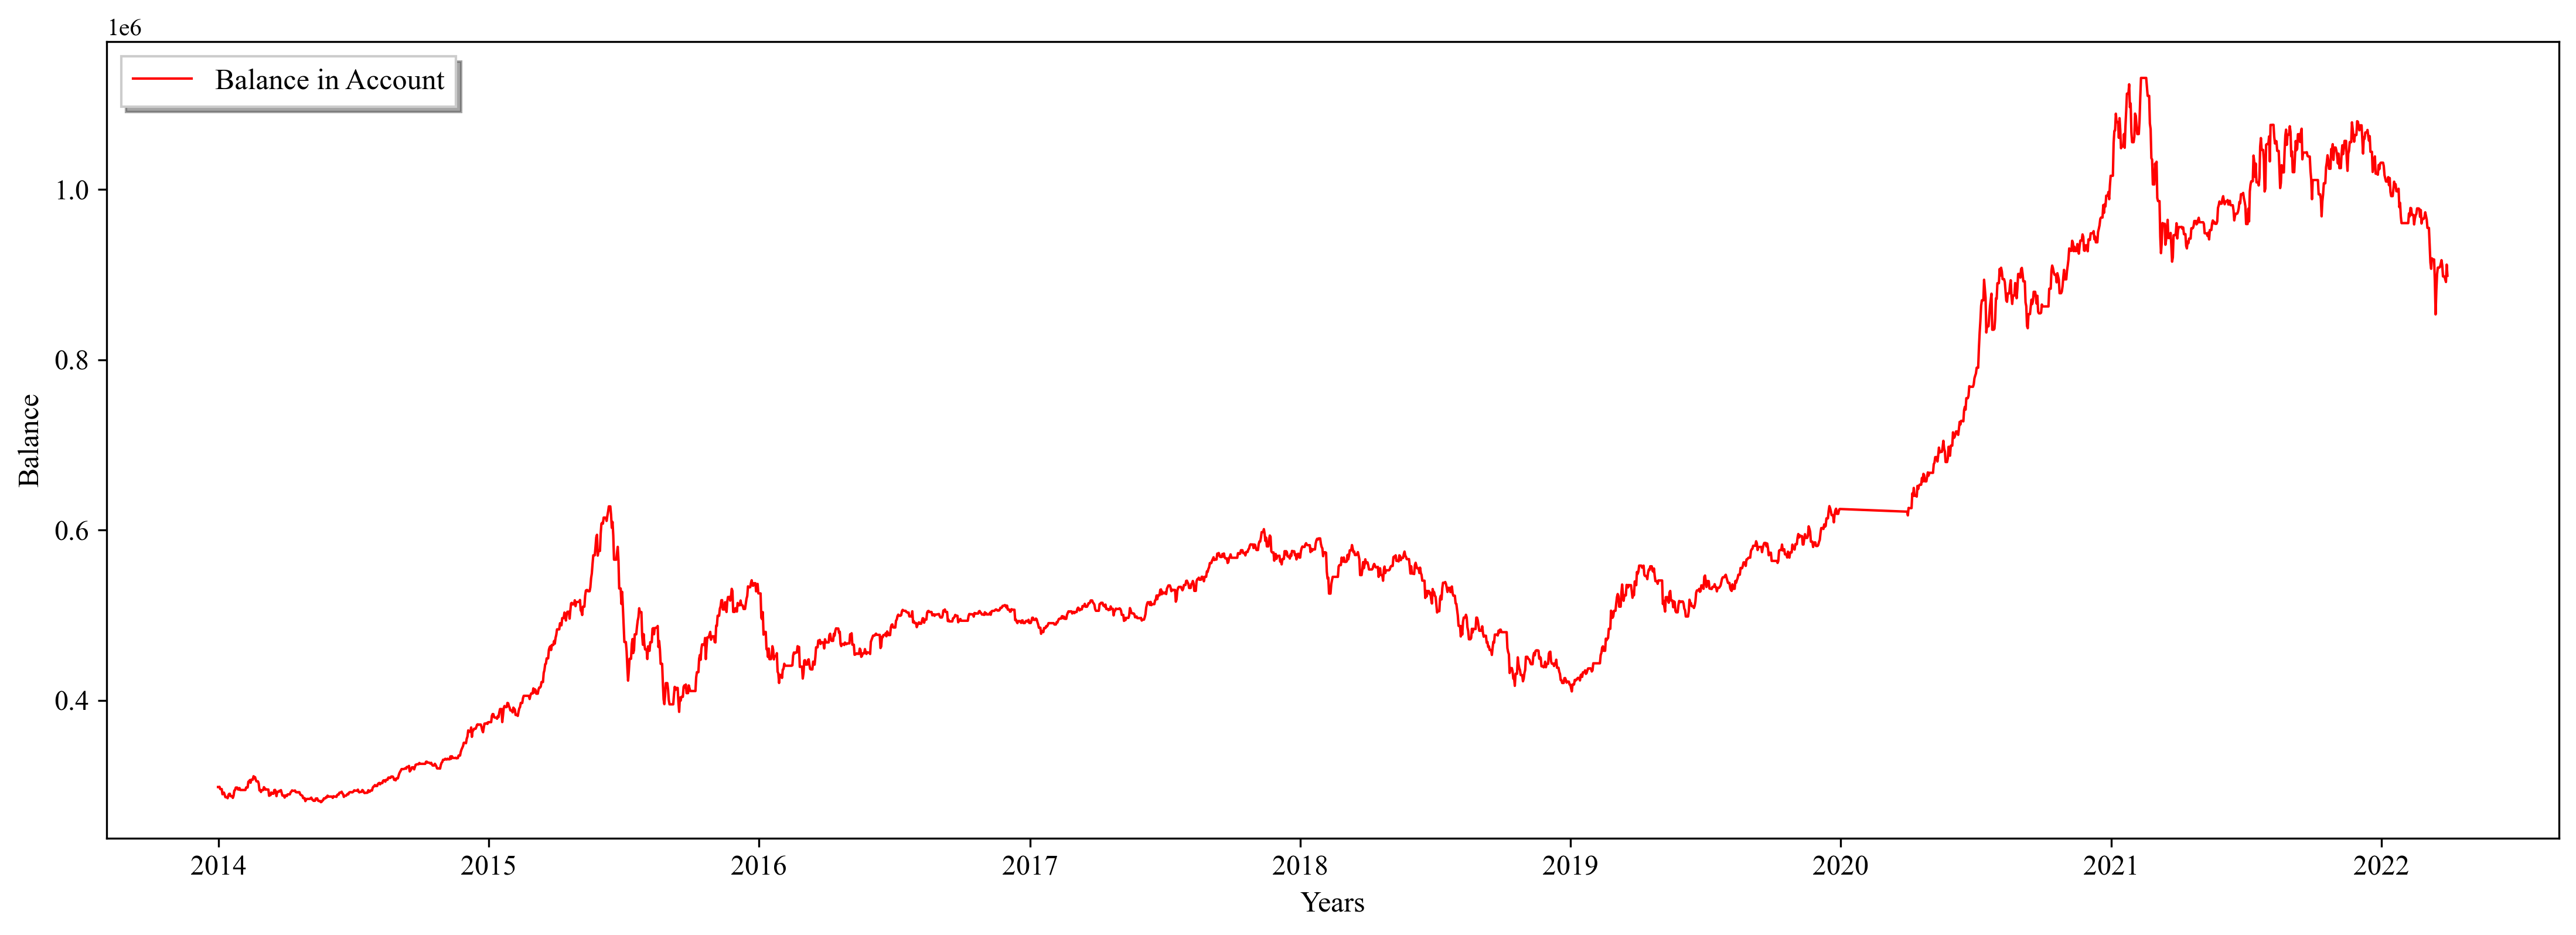

In [17]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 300)
ax1 = fig.add_subplot(111)
ax1.plot(long_backtest_result.ACCOUNT_NAV, "-",color = "red",linewidth = 1,label = "Net Value")
# ax1.plot(short_backtest_result.ACCOUNT_NAV, "-",color = "#0000FF",linewidth = 1,label = "Net Value")
# ax1.plot(300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV, "--",color = "orange",linewidth = 1,label = "Net Value")
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)
plt.savefig("./Output/BalanceInAccount(DailyReturn(all)).png")

#### 4.风险收益指标

In [18]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.5701748173481307

In [19]:
# annual return
empyrical.annual_return(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values,period = 'daily',annualization = 365)

0.1476195464007659

In [20]:
# max drawdown
((long_backtest_result.ACCOUNT_NAV.cummax() - long_backtest_result.ACCOUNT_NAV)/(long_backtest_result.ACCOUNT_NAV.cummax())).max()

0.38410310957345345